### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [17]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

Part 1

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


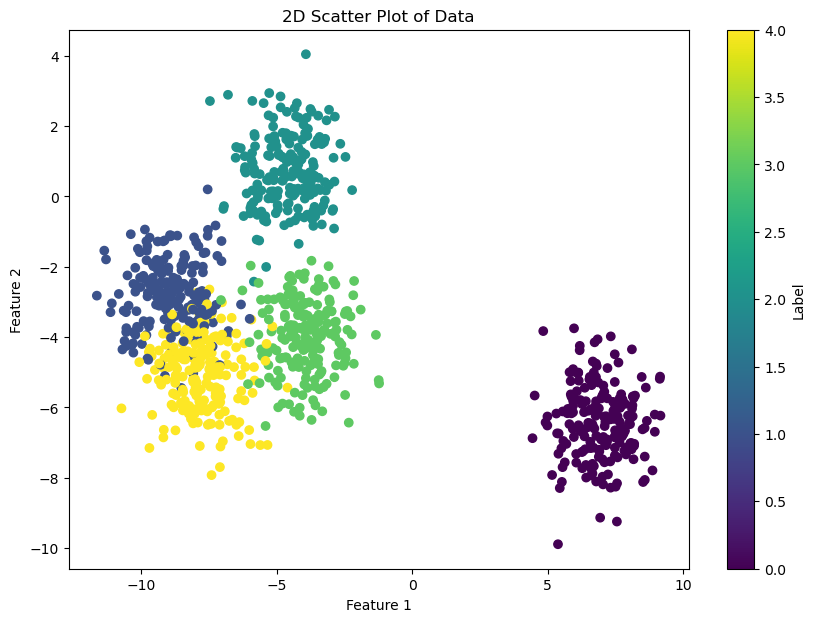

(array([[-8.46474567, -3.45517123],
        [-9.93233853, -2.31955228],
        [-9.30833095, -1.9725388 ],
        ...,
        [-3.42236789,  1.69166315],
        [-3.31992823, -6.1090681 ],
        [-3.62495834,  0.11710104]]),
 array([1., 1., 1., 2., 1., 4., 4., 1., 3., 2., 3., 0., 4., 3., 1., 0., 4.,
        4., 2., 2., 1., 4., 4., 1., 0., 1., 4., 0., 0., 3., 1., 3., 2., 3.,
        2., 0., 0., 0., 3., 1., 1., 2., 2., 1., 2., 2., 2., 4., 2., 4., 3.,
        0., 2., 0., 0., 0., 0., 1., 4., 1., 0., 2., 2., 0., 0., 0., 4., 0.,
        4., 0., 3., 3., 1., 4., 1., 2., 0., 1., 4., 3., 0., 4., 3., 1., 2.,
        3., 0., 3., 0., 0., 3., 0., 4., 2., 4., 0., 3., 2., 4., 4., 1., 0.,
        0., 2., 0., 3., 4., 3., 0., 1., 1., 3., 3., 3., 1., 3., 3., 4., 3.,
        1., 3., 3., 2., 1., 3., 0., 1., 4., 4., 4., 3., 3., 2., 1., 1., 3.,
        1., 0., 4., 0., 2., 4., 3., 4., 1., 2., 3., 1., 3., 4., 4., 2., 4.,
        4., 1., 4., 4., 4., 1., 2., 1., 3., 0., 2., 1., 0., 3., 3., 0., 4.,
        1

In [4]:
def plot_data(filepath):
    # Load the data
    data = np.load(filepath)

    # Separate the features and the labels
    X = data[:, :2]  # Features
    y = data[:, 2]   # Labels

    # Create a scatter plot
    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.colorbar(label='Label')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('2D Scatter Plot of Data')
    plt.show()

    return X, y # Return the features and the labels


# Use the function
plot_data("../../homeworks/hw_data/hw6_data_1.npy")

Part 2

Best bandwidth:  0.4724137931034482


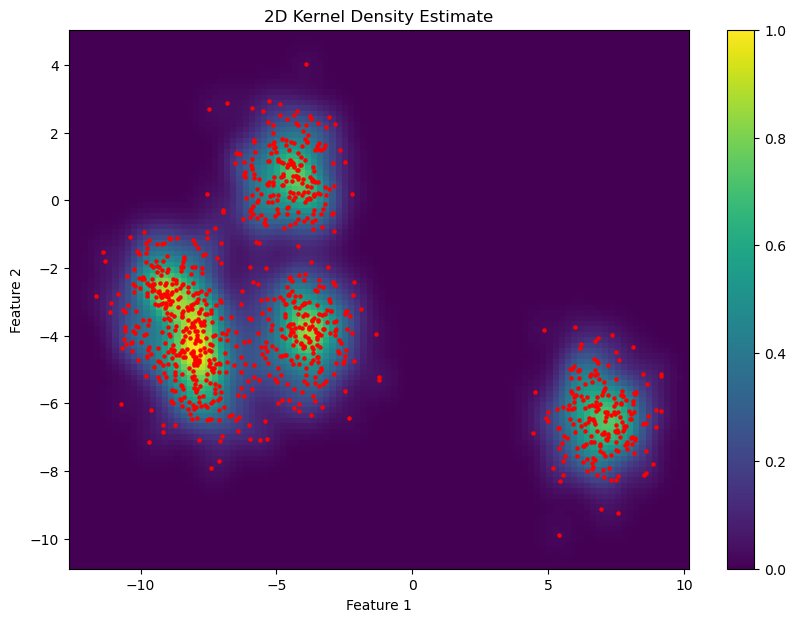

In [7]:
def plot_kde(X):
    # Define the grid search parameters
    params = {'bandwidth': np.linspace(0.1, 1.0, 30)}

    # Perform grid search cross-validation
    grid = GridSearchCV(KernelDensity(), params, cv=5)
    grid.fit(X)

    # Print the best bandwidth
    print("Best bandwidth: ", grid.best_estimator_.bandwidth)

    # Fit the KDE model with the best bandwidth
    kde = KernelDensity(bandwidth=grid.best_estimator_.bandwidth)
    kde.fit(X)

    # Create a grid of points for the plot
    x_grid = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y_grid = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    XY_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # Compute the KDE values for the grid of points
    Z = np.exp(kde.score_samples(XY_grid)).reshape(X_grid.shape)

    # Plot the KDE
    plt.figure(figsize=(10, 7))
    plt.imshow(Z, origin='lower', aspect='auto', extent=(X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1), cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c='r', s=5)
    plt.title('2D Kernel Density Estimate')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    plt.show()


# Use the functions
plot_kde(X)

part 3

Best k value:  48


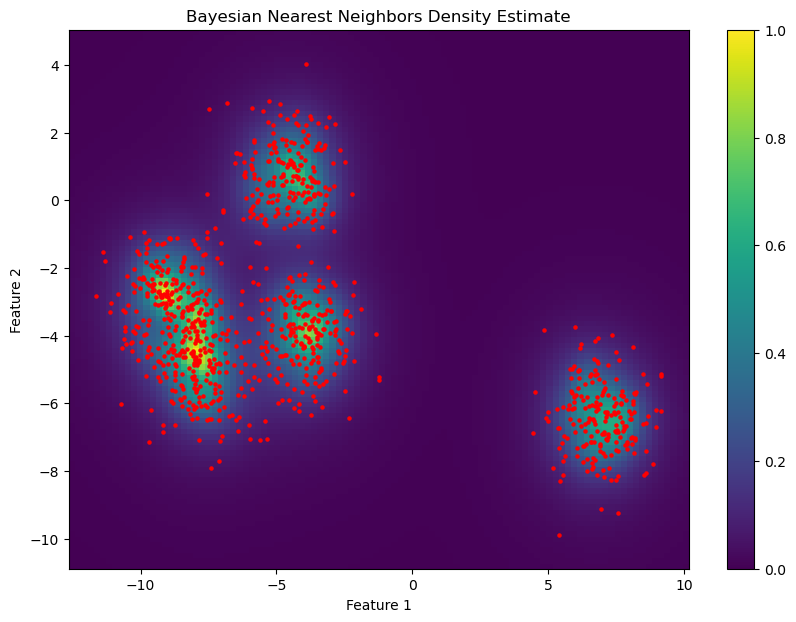

In [16]:
# List of potential k values
k_values = range(1, 81)

# List to store cross-validation scores
cv_scores = []

# Perform 5-fold cross-validation for each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the k value that gives the highest cross-validation score
best_k = k_values[cv_scores.index(max(cv_scores))]
print("Best k value: ", best_k)

def plot_knn_density(X, k):
    # Fit the KNeighborsDensity model
    knn = KNeighborsDensity('bayesian', n_neighbors=k)
    knn.fit(X)

    # Create a grid of points for the plot
    x_grid = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y_grid = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    XY_grid = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # Compute the density values for the grid of points
    Z = knn.eval(XY_grid).reshape(X_grid.shape)

    # Plot the density
    plt.figure(figsize=(10, 7))
    plt.imshow(Z, origin='lower', aspect='auto', extent=(X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1), cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c='r', s=5)
    plt.title('Bayesian Nearest Neighbors Density Estimate')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    plt.show()

# Use the function
plot_knn_density(X, k=48)


For picking a k, I have a small code portion performing k-fold cross-validation for a range of k values in a k-Nearest Neighbors (k-NN) classifier to hopefully find the optimal k.

part 4

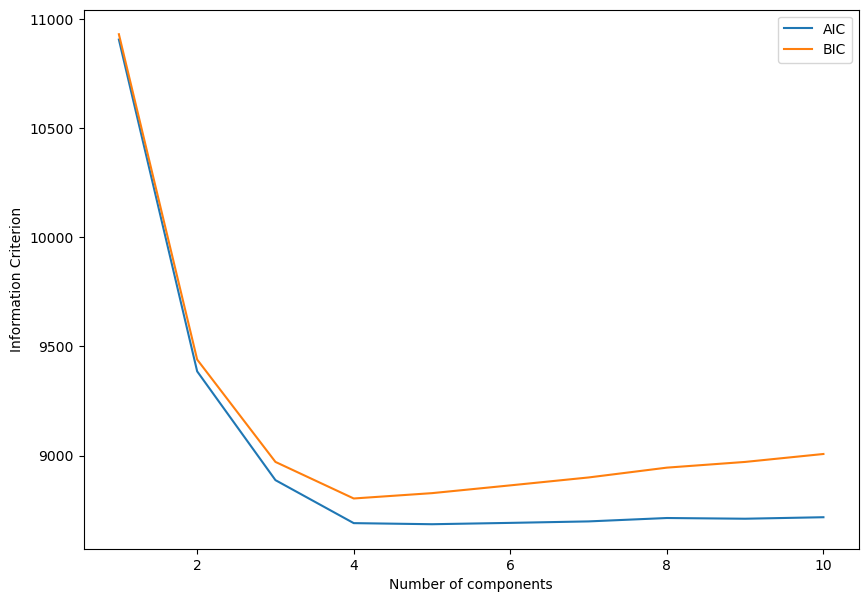

Optimal number of components according to BIC:  4


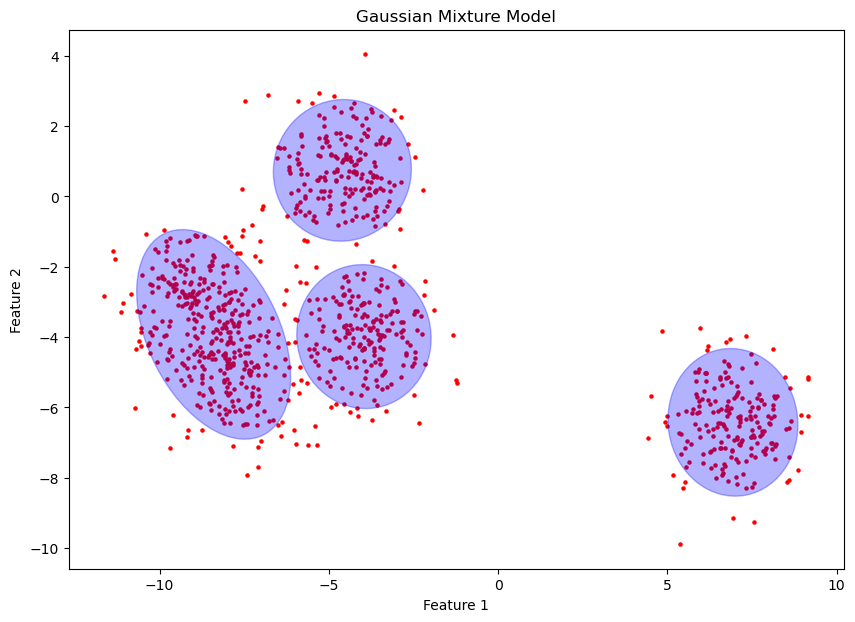

In [24]:
def fit_gmm_and_plot(X, draw_ellipse, n_components_range=range(1, 11)):
    # List to store the AIC and BIC values
    aic_values = []
    bic_values = []

    # Fit a GMM for 1 to 10 components
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        aic_values.append(gmm.aic(X))
        bic_values.append(gmm.bic(X))

    # Plot the AIC and BIC values
    plt.figure(figsize=(10, 7))
    plt.plot(n_components_range, aic_values, label='AIC')
    plt.plot(n_components_range, bic_values, label='BIC')
    plt.xlabel('Number of components')
    plt.ylabel('Information Criterion')
    plt.legend()
    plt.show()

    # Find the optimal number of components according to the BIC
    optimal_components = bic_values.index(min(bic_values)) + 1
    print("Optimal number of components according to BIC: ", optimal_components)

    # Fit the GMM with the optimal number of components
    gmm_optimal = GaussianMixture(n_components=optimal_components)
    gmm_optimal.fit(X)

    # Plot the data set, the GMM component mean locations, and the 2-sigma GMM component ellipses
    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c='r', s=5)
    for i in range(gmm_optimal.n_components):
        draw_ellipse(gmm_optimal.means_[i], gmm_optimal.covariances_[i], scales=[2], color='b', alpha=0.3)
    plt.title('Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Use the function
fit_gmm_and_plot(X, draw_ellipse)

/Users/culbreks/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


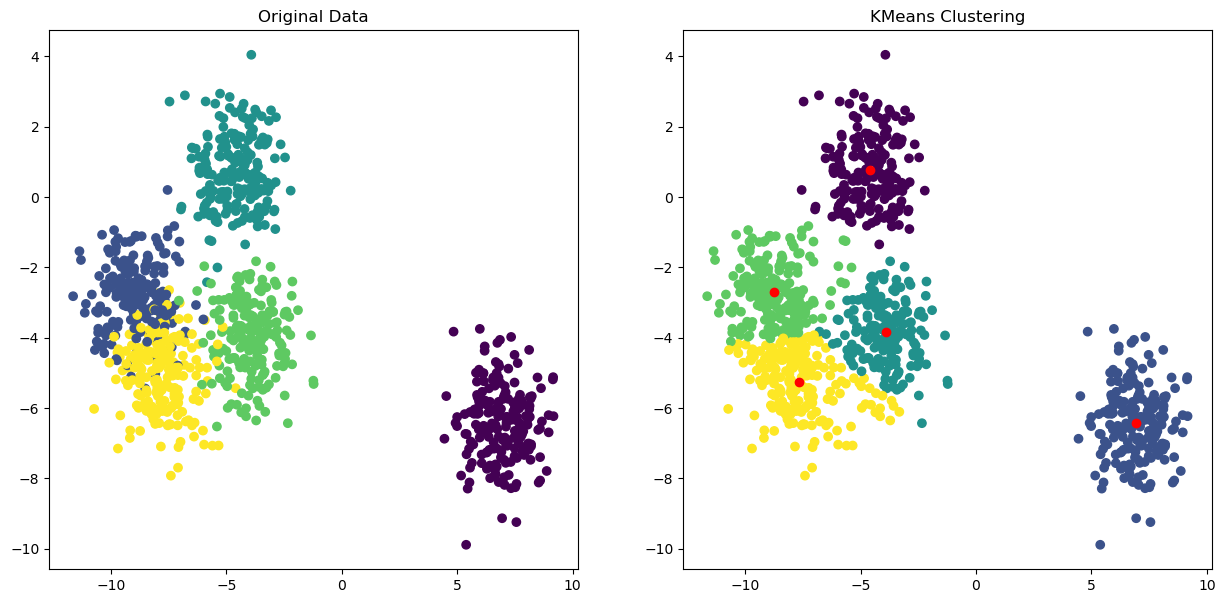

In [26]:
def kmeans_clustering(X, y, n_clusters):
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit the KMeans model
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_scaled)

    # Find the cluster centers and inverse transform them
    centers_scaled = kmeans.cluster_centers_
    centers = scaler.inverse_transform(centers_scaled)

    # Predict the labels for the scaled data
    labels = kmeans.predict(X_scaled)

    # Make a two-panel side by side plot
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Original data colored by its labels
    ax[0].scatter(X[:, 0], X[:, 1], c=y)
    ax[0].set_title('Original Data')

    # Data colored by the KMeans predicted labels, with cluster centers superposed
    ax[1].scatter(X[:, 0], X[:, 1], c=labels)
    ax[1].scatter(centers[:, 0], centers[:, 1], c='red')  # cluster centers
    ax[1].set_title('KMeans Clustering')

    plt.show()

# Use the function
kmeans_clustering(X, y, n_clusters=5)

This is a explaination to myself of what is happening with kmeans.predict

So the Kmeans clustering is done on a dataset with 10 features and it is divided into two clusters. Which the KMeans algorithm predicts the cluster that each data point belongs to. Which in the left figure we see that the Kmeans.predict(X_scaled) is used to predict which cluster each data point will belong to, where X_scaled are the scaled version of the original data set.

First the Kmeans model is first trained suing the kmeans.fit method on a dataset which the algorithm ideantifies k numebr of centroids in the data

Then the model is trained and kmeans.predict is assigning each data point in the dataset to the nearest centroids. 

Then the kmeans.predict method returns an array of predicted cluster indices corresponding to each input sample in X